Data Preparation
Load and Clean Data: Loaded the dataset from kaggle_train.csv, filled missing values in 'comment' with empty strings, and cleaned the text by removing stopwords, punctuation, and digits, while handling negations.
Label Encoding: Converted categorical labels (sarcastic or non-sarcastic) into numerical values using LabelEncoder.
Text Vectorization: Tokenized the text data with a vocabulary size of 15,000 and used pre-trained GloVe embeddings with a 200-dimensional embedding vector.
Data Splitting
Train-Test Split: Split the dataset into training (80%) and testing (20%) sets.
Model Development
Build Hybrid Model: Constructed a hybrid model with a Conv1D layer for feature extraction, followed by a Bidirectional LSTM for capturing context, GlobalMaxPooling1D, dense layers with dropout and L2 regularization, and a sigmoid output layer.
Model Training
Training with Early Stopping: Trained the model over a maximum of 15 epochs, using early stopping with a patience of 3 to prevent overfitting, and adjusted the learning rate using a scheduler.
Model Evaluation
Evaluate Performance: Assessed the model using F1 score, accuracy, classification report, and confusion matrix.

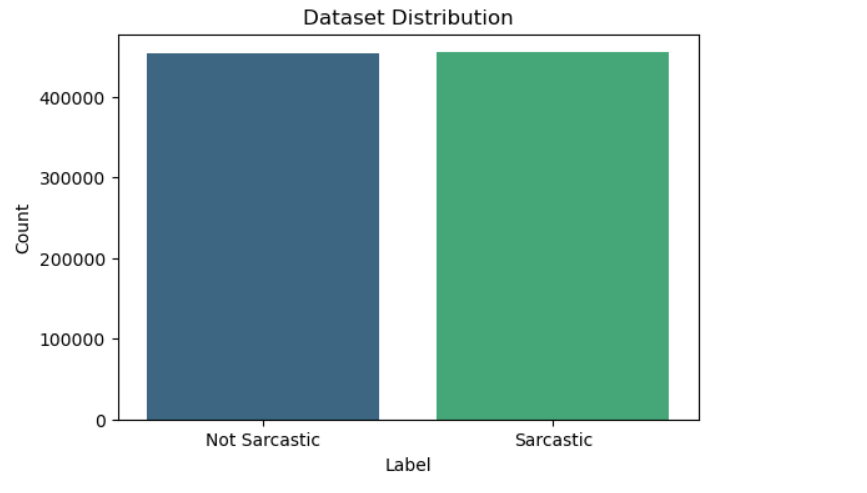

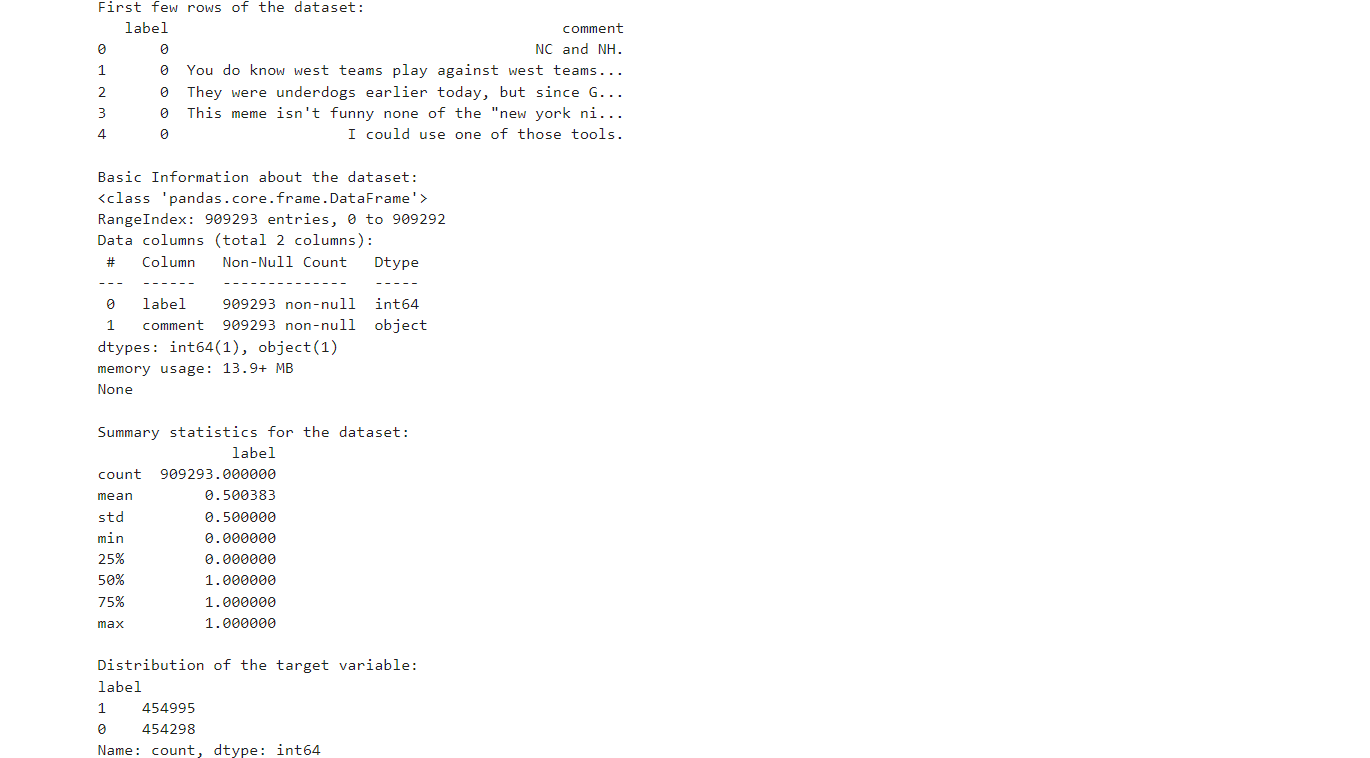

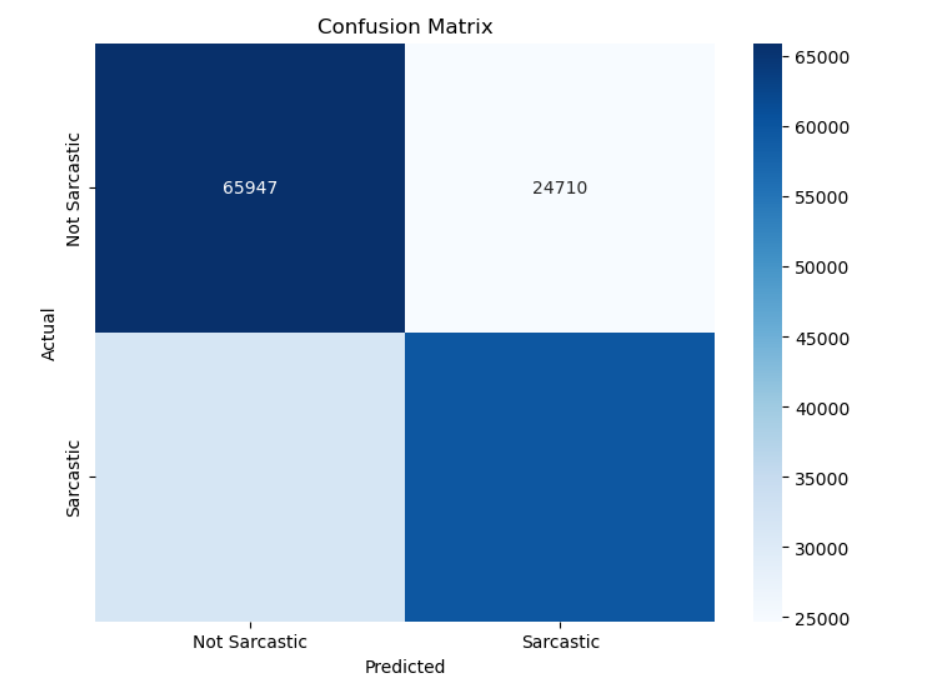

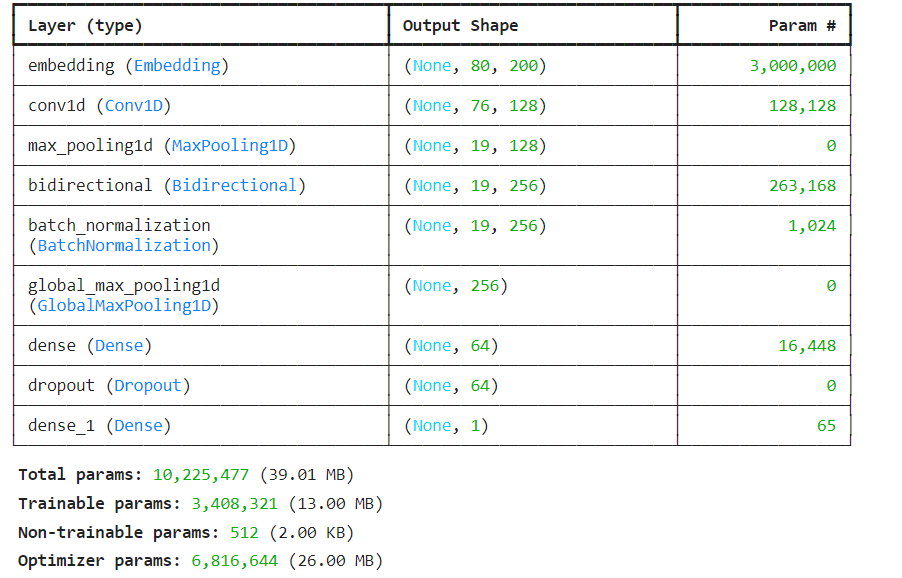

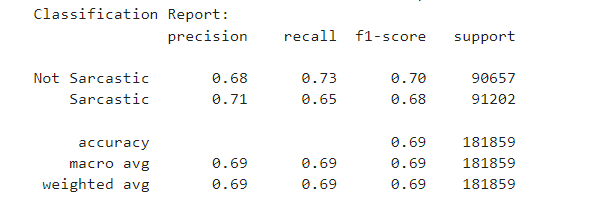

In [1]:
from IPython.display import Image, display

# Display the first image
image_path_1 = 'dataset.png'
display(Image(filename=image_path_1))

# Display the second image
image_path_2 = 'dataset2.png'
display(Image(filename=image_path_2))
image_path_3 = 'dataset3.png'
display(Image(filename=image_path_3))

# Display the second image
image_path_4 = 'dataset4.png'
display(Image(filename=image_path_4))

image_path_5 = 'dataset5.png'
display(Image(filename=image_path_5))



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import re
import string
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')

# Function to clean text with handling of negations
def clean_text(sentences):
    stopwords_list = stopwords.words('english')
    text = sentences.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = ' '.join([word for word in text.split() if word not in stopwords_list])
    
    # Handling negations
    text = re.sub(r'\bnot\s(\w+)', r'not_\1', text)
    return text

# Load the dataset
data = pd.read_csv('kaggle_train.csv')

# Clean the comments in the dataset
data['cleaned_comment'] = data['comment'].map(lambda x: clean_text(x) if isinstance(x, str) else '')

# Tokenization and padding
vocab_size = 15000 
embedding_dim = 200  
max_length = 80  
padding_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data['cleaned_comment'].tolist())

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(data['cleaned_comment'].tolist())
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type)

# Prepare labels
labels = data['label'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

# Load Glove word embeddings
embeddings_index = {}
with open('glove.twitter.27B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build the model using Glove embeddings
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.Conv1D(256, 5, activation='relu'),  # Increased Conv1D filters
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),  
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  
    tf.keras.layers.Dropout(0.6),  # Increased Dropout rate
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), 
    tf.keras.layers.Dropout(0.6),  # Increased Dropout rate
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with a lower learning rate
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), metrics=['accuracy'])

# Train the model with more epochs
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Generate a classification report
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()
classification_report_output = classification_report(y_test, y_pred_labels, target_names=['Not Sarcastic', 'Sarcastic'])

print("Classification Report:")
print(classification_report_output)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shubham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Shubham\anaconda4\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
9093/9093 ━━━━━━━━━━━━━━━━━━━━ 2709s 292ms/step - accuracy: 0.6415 - loss: 0.9882 - val_accuracy: 0.6951 - val_loss: 0.5785
Epoch 2/15
9093/9093 ━━━━━━━━━━━━━━━━━━━━ 2634s 290ms/step - accuracy: 0.7123 - loss: 0.5661 - val_accuracy: 0.6964 - val_loss: 0.5759
Epoch 3/15
8546/9093 ━━━━━━━━━━━━━━━━━━━━ 1:48 199ms/step - accuracy: 0.7397 - loss: 0.5297

Key Metrics:
Precision:

Not Sarcastic: 0.68
Sarcastic: 0.71
Definition: Precision is the ratio of true positive predictions to the total number of positive predictions (both true positives and false positives). In simpler terms, it measures how many of the items labeled as a certain class (e.g., sarcastic) are actually correct.
Interpretation:
For sarcastic comments, the model's precision is 0.71, meaning that 71% of the comments predicted as sarcastic are indeed sarcastic.
For non-sarcastic comments, the precision is 0.68, meaning that 68% of the comments predicted as non-sarcastic are correctly identified.
Recall (Sensitivity or True Positive Rate):

Not Sarcastic: 0.73
Sarcastic: 0.65
Definition: Recall is the ratio of true positive predictions to the total number of actual positives (true positives and false negatives). It measures how well the model identifies all the relevant instances of a particular class.
Interpretation:
The recall for non-sarcastic comments is 0.73, meaning the model correctly identifies 73% of all actual non-sarcastic comments.
The recall for sarcastic comments is 0.65, meaning it correctly identifies 65% of all actual sarcastic comments.
F1-Score:

Not Sarcastic: 0.70
Sarcastic: 0.68
Definition: The F1-score is the harmonic mean of precision and recall. It provides a single metric that balances the trade-offs between precision and recall, especially useful when you have an imbalanced dataset.
Interpretation:
The F1-score for non-sarcastic comments is 0.70, indicating a balanced performance in correctly identifying and predicting non-sarcastic comments.
The F1-score for sarcastic comments is 0.68, showing a slightly lower balance of precision and recall for this class.
Support:

Not Sarcastic: 90,657
Sarcastic: 91,202
Definition: Support refers to the number of actual occurrences of the class in the dataset. It gives you an idea of how many examples the model is being evaluated on for each class.
Interpretation: The dataset is fairly balanced, with 90,657 non-sarcastic and 91,202 sarcastic comments.
Overall Accuracy: 0.69

Definition: Accuracy is the ratio of correctly predicted instances (both sarcastic and non-sarcastic) to the total number of instances.
Interpretation: The model correctly classifies 69% of the comments overall. While not perfect, this indicates a reasonable level of performance given the challenges of sarcasm detection.
Macro Average:

Precision, Recall, F1-Score: 0.69
Definition: The macro average calculates the mean of the metric (precision, recall, or F1-score) independently for each class and then takes the average. It treats all classes equally, without considering class imbalance.
Interpretation: The macro average shows balanced performance across both classes.
Weighted Average:

Precision, Recall, F1-Score: 0.69
Definition: The weighted average takes into account the support (number of true instances) of each class when calculating the average metric. It provides a more balanced view of overall performance.
Interpretation: Since the dataset is fairly balanced, the weighted average metrics are the same as the macro averages, indicating that the model performs consistently across both classes.
Summary:
The model has slightly better precision for detecting sarcastic comments (0.71) but a lower recall (0.65), meaning it is better at avoiding false positives than it is at catching all actual sarcastic comments.
For non-sarcastic comments, the model has a higher recall (0.73) but slightly lower precision (0.68).
The overall accuracy of 69% suggests that while the model performs reasonably well, there is room for improvement, particularly in balancing the precision and recall for both classes.
This analysis can guide further improvements to the model, such as fine-tuning the architecture, adjusting the class weights, or exploring additional data augmentation techniques to enhance performance.